In [1]:
## 데이터셋 불러오기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
## 배열 확인
X, y = mnist["data"], mnist["target"]
print(X.shape)  # 이미지가 70,000개 있고, 784개의 특성(28x28픽셀)이 존재
print(y.shape)

(70000, 784)
(70000,)


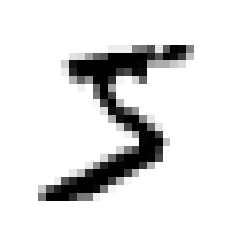

In [3]:
## 배열의 특성을 추출해서 그림 그리기
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [4]:
## y를 정수로 변환
import numpy as np
y = y.astype(np.uint8)

In [5]:
## 앞쪽 60,000개 이미지를 훈련 데이터로 분리
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
## 숫자 5를 감지하는 이진 분류기 훈련
y_train_5 = (y_train == 5) # 5는 True, 이 외의 숫자는 모두 False
y_test_5 = (y_test == 5)

In [7]:
## SGDClassifier를 이용한 분류기 훈련
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
## 정확도 측정
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=5)

# cv값은 교차 검증(Cross Validatuon)을 위한 훈련세트를 몇 개(k개)로 나눌 것인지에 대한 것으로, 기본값은 K=5
# 총 5개 폴드(A, B, C, D, E)로 나누어, 
# 1회 : 검증{A} / 학습{B, C, D, E}
# 2회 : 검증{B} / 학습{A, C, D, E} 
# 3회 : 검증{C} / 학습{A, B, D, E} 
# 4회 : 검증{D} / 학습{A, B, C, E} 
# 5회 : 검증{E} / 학습{A, B, C, D}
# 총 5회 반복 에 대한 평균값을 반영  

array([0.95466667, 0.96975   , 0.9635    , 0.96533333, 0.94841667])

In [9]:
## 예측 클래스 생성

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

In [10]:
## 혼돈행렬

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53115,  1464],
       [  916,  4505]])

ㆍ숫자 '5' 이미지를 '5'가 맞는 것으로 정확히 분류 : 3,530개(TP, True-Positive)

ㆍ숫자 '5' 이미지를 '5'가 *아닌 것으로 잘못 분류* : 1,891개(FN, False-Negative)

ㆍ숫자 '5'가 아닌 이미지를 '5'가 *맞는 것으로 잘못 분류* : 687개(FP, False-Positive)

ㆍ숫자 '5'가 아닌 이미지를 '5'가 아닌 것으로 정확히 분류 : 53,892개(TN, True-Negative)


# **60,000개 데이터 중 숫자 '5'의 이미지는 10% 밖에 되지 않아, 추가 지표 필요**

# * **정밀도 : TP/(TP+FP) : 모델이 5라고 예측한 것 중 실제 5인 이미지의 비율** 

# * **재현율 : TP/(TP+FN) : 실제 5인 이미지를 모델이 5라고 예측한 비율**

In [11]:
## 정밀도 계산

from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.7547327860613168

In [12]:
## 재현율 계산

recall_score(y_train_5, y_train_pred)

0.8310274857037447

정밀도와 재현율을 하나의 숫자로 만들면 편리(정밀도와 재현율의 조화평균)
# **F1스코어 : 2x(정밀도x재현율)/(정밀도+재현율)**

In [13]:
## F1스코어 계산

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.791044776119403

# **정밀도/재현율 트레이드 오프**

SGDClassifier는 결점함수를 사용
결정 임계값을 어떻게 정하는지에 따라 정밀도와 재현율이 바뀌며,
정밀도와 재현율은 트레이드 오프 관계를 가짐.

In [14]:
## 임계값 지정

y_scores = sgd_clf.decision_function([some_digit]) # decision_function 호출 

threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [15]:
## 임계값을 8000으로 높인 경우

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

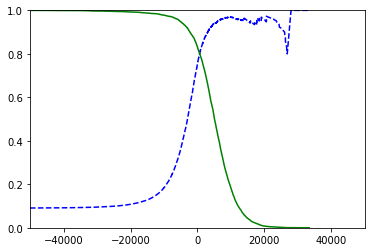

In [16]:
## precision_recall_curve() 함수를 이용하여 정밀도 및 재현율 계산

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5, method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): # 맷플롯립을 이용하여 그림 확인
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.axis([-50000, 50000, 0, 1]) 

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)                           
plt.show()

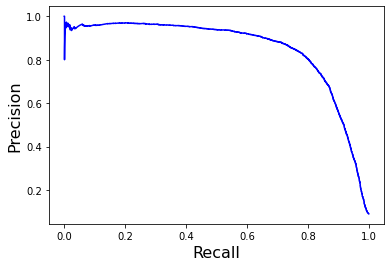

In [17]:
## 좋은 임계값을 찾기 위해서는 재현율에 대한 정밀도 곡선을 확인 

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-")
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)

plot_precision_vs_recall(precisions, recalls)                           
plt.show()

In [18]:
# 재현율 80% 근처에서 정밀도가 급격하게 줄어들기 때문에 이 하강점 직전을 선택(예를 들면 재현율 60% 지점)

## 정밀도 90%이상이 목표인 경우
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90)

0.9002016129032258

In [19]:
# 이 때의 재현율
recall_score(y_train_5, y_train_pred_90)

0.6589190186312488